In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [3]:
new_df = pd.read_csv("/content/Thyroid-Dataset.csv")

In [4]:
new_df.head().T

,0,1,2,3,4
age,29,41,36,32,60
sex,F,F,F,F,F
on thyroxine,False,False,False,False,False
query on thyroxine,False,False,False,False,False
on antithyroid medication,False,False,False,False,False
sick,False,False,False,False,False
pregnant,False,False,False,False,False
thyroid surgery,False,False,False,False,False
I131 treatment,False,False,False,False,False
query hypothyroid,False,False,False,False,False


In [5]:
new_df.tail().T

,9166,9167,9168,9169,9170
age,56,22,69,47,31
sex,M,M,M,F,M
on thyroxine,False,False,False,False,False
query on thyroxine,False,False,False,False,False
on antithyroid medication,False,False,False,False,False
sick,False,False,False,False,False
pregnant,False,False,False,False,False
thyroid surgery,False,False,False,False,False
I131 treatment,False,False,False,False,False
query hypothyroid,False,False,False,False,True


In [6]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9171 entries, 0 to 9170
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        9171 non-null   int64  
 1   sex                        8864 non-null   object 
 2   on thyroxine               9171 non-null   bool   
 3   query on thyroxine         9171 non-null   bool   
 4   on antithyroid medication  9171 non-null   bool   
 5   sick                       9171 non-null   bool   
 6   pregnant                   9171 non-null   bool   
 7   thyroid surgery            9171 non-null   bool   
 8   I131 treatment             9171 non-null   bool   
 9   query hypothyroid          9171 non-null   bool   
 10  query hyperthyroid         9171 non-null   bool   
 11  lithium                    9171 non-null   bool   
 12  goitre                     9171 non-null   bool   
 13  tumor                      9171 non-null   bool 

In [8]:
new_df.shape

(9171, 23)

Our dataset has extreme outliers, especially in important continuous features like age, TSH, T3, TT4, T4U, FTI

In [9]:
# Separate numeric and categorical columns
num_cols = new_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [10]:
new_df.describe()

,age,TSH,T3,TT4,T4U,FTI
count,9171.000000,8329.000000,6568.000000,8730.000000,8363.000000,8370.000000
mean,73.560680,5.218993,1.970629,108.700305,0.976056,113.640746
std,1184.041182,24.185398,0.887579,37.522670,0.200360,41.551650
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000
75%,68.000000,2.700000,2.300000,126.000000,1.065000,128.000000
max,65526.000000,530.000000,18.000000,600.000000,2.330000,881.000000


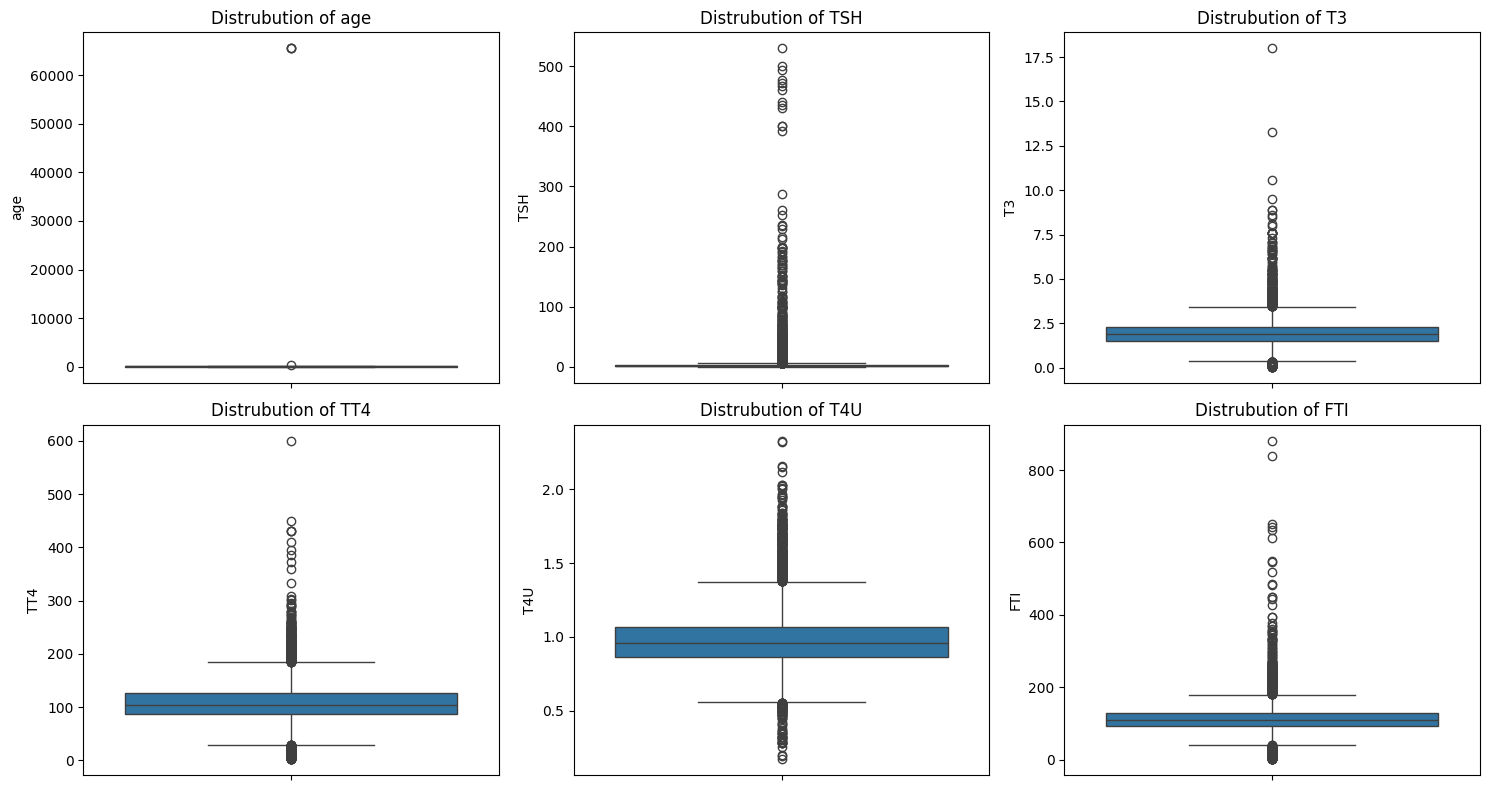

In [11]:
plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols):
  plt.subplot(2,3,i+1)
  sns.boxplot(new_df[col])
  plt.title(f"Distrubution of {col}")

plt.tight_layout()
plt.show()

In [12]:
# Backup Dataframe for future usage
df = new_df.copy()

# Step-by-Step Plan to Treat Outliers Without Dropping
We'll apply these preprocessing steps:

- Log-transform highly skewed features
- Cap extreme values (winsorize) using percentiles
- Scale the features using RobustScaler

In [13]:
# Log Transformation (for right-skewed features)
# These features have heavy right-skew based on stats:
# → TSH, TT4, FTI (also T3 mildly)

new_df['TSH_log'] = np.log1p(new_df['TSH'])      # log1p(x) = log(1 + x), safe for 0
new_df['TT4_log'] = np.log1p(new_df['TT4'])
new_df['FTI_log'] = np.log1p(new_df['FTI'])
new_df['T3_log'] = np.log1p(new_df['T3'])

In [14]:
# Winsorize (cap extreme values)
# This avoids distortions from rare but extreme values, preserves rows:

def winsorize_series(s, lower=0.01, upper=0.99):
    low_val = s.quantile(lower)
    high_val = s.quantile(upper)
    return s.clip(lower=low_val, upper=high_val)

In [15]:
new_df['Age'] = new_df['age']

features_to_winsor = ['Age', 'TSH_log', 'TT4_log', 'FTI_log', 'T3_log', 'T4U']

for col in features_to_winsor:
    new_df[col + '_capped'] = winsorize_series(new_df[col])

In [ ]:
new_df.describe()

,age,TSH,T3,TT4,T4U,FTI,TSH_log,TT4_log,FTI_log,T3_log,Age,Age_capped,TSH_log_capped,TT4_log_capped,FTI_log_capped,T3_log_capped,T4U_capped
count,9171.000000,8329.000000,6568.000000,8730.000000,8363.000000,8370.000000,8329.000000,8730.000000,8370.000000,6568.000000,9171.000000,9171.000000,8329.000000,8730.000000,8370.000000,6568.000000,8363.000000
mean,73.560680,5.218993,1.970629,108.700305,0.976056,113.640746,1.009677,4.631019,4.677226,1.050459,73.560680,52.149820,1.003598,4.635981,4.682039,1.049002,0.975824
std,1184.041182,24.185398,0.887579,37.522670,0.200360,41.551650,0.892805,0.411052,0.404971,0.275446,1184.041182,18.738271,0.864552,0.367167,0.348660,0.264579,0.191794
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.004988,1.098612,0.875469,0.048790,1.000000,14.000000,0.009950,2.833213,2.872653,0.262364,0.550000
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000,0.378436,4.477337,4.543295,0.916291,37.000000,37.000000,0.378436,4.477337,4.543295,0.916291,0.860000
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,0.875469,4.653960,4.700480,1.064711,55.000000,55.000000,0.875469,4.653960,4.700480,1.064711,0.960000
75%,68.000000,2.700000,2.300000,126.000000,1.065000,128.000000,1.308333,4.844187,4.859812,1.193922,68.000000,68.000000,1.308333,4.844187,4.859812,1.193922,1.065000
max,65526.000000,530.000000,18.000000,600.000000,2.330000,881.000000,6.274762,6.398595,6.782192,2.944439,65526.000000,87.000000,4.562920,5.423670,5.507842,1.791759,1.693800


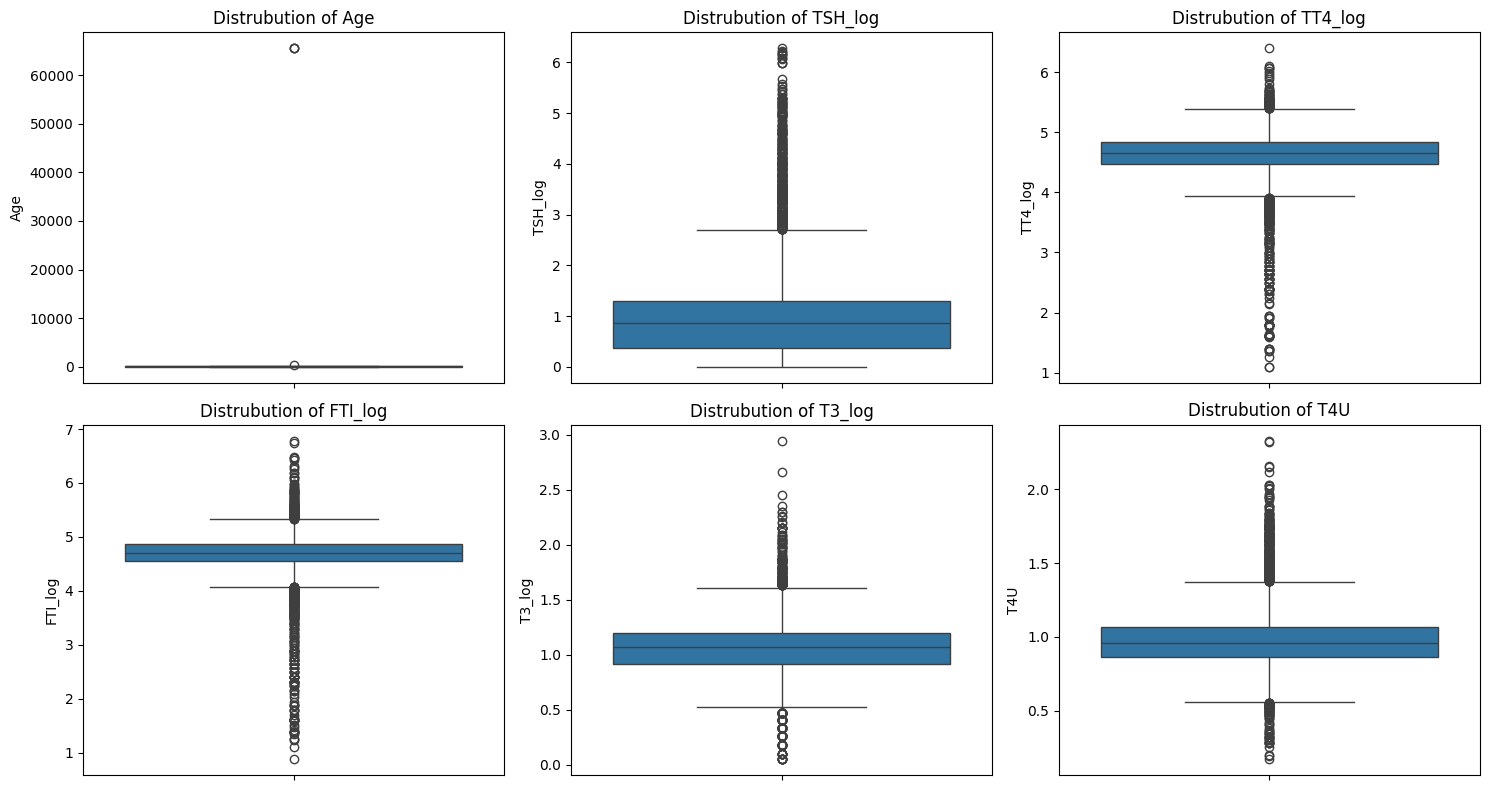

In [16]:
plt.figure(figsize=(15,8))
for i, col in enumerate(features_to_winsor):
  plt.subplot(2,3,i+1)
  sns.boxplot(new_df[col])
  plt.title(f"Distrubution of {col}")

plt.tight_layout()
plt.show()

In [17]:
# Robust Scaling (resistant to outliers

robust_features = [col + '_capped' for col in features_to_winsor]
scaler = RobustScaler()
scaled_array = scaler.fit_transform(new_df[robust_features])

# Replace original columns with scaled ones (or create new df)
new_df_scaled = pd.DataFrame(scaled_array, columns=robust_features)

In [18]:
new_df_scaled.describe()

,Age_capped,TSH_log_capped,TT4_log_capped,FTI_log_capped,T3_log_capped,T4U_capped
count,9171.000000,8329.000000,8730.000000,8370.000000,6568.000000,8363.000000
mean,-0.091941,0.137789,-0.049009,-0.058265,-0.056579,0.077189
std,0.604460,0.929730,1.000864,1.101551,0.952987,0.935578
min,-1.322581,-0.930769,-4.963188,-5.774806,-2.889967,-2.000000
25%,-0.580645,-0.534503,-0.481459,-0.496609,-0.534593,-0.487805
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.419355,0.465497,0.518541,0.503391,0.465407,0.512195
max,1.032258,3.965443,2.098157,2.550763,2.618752,3.579512


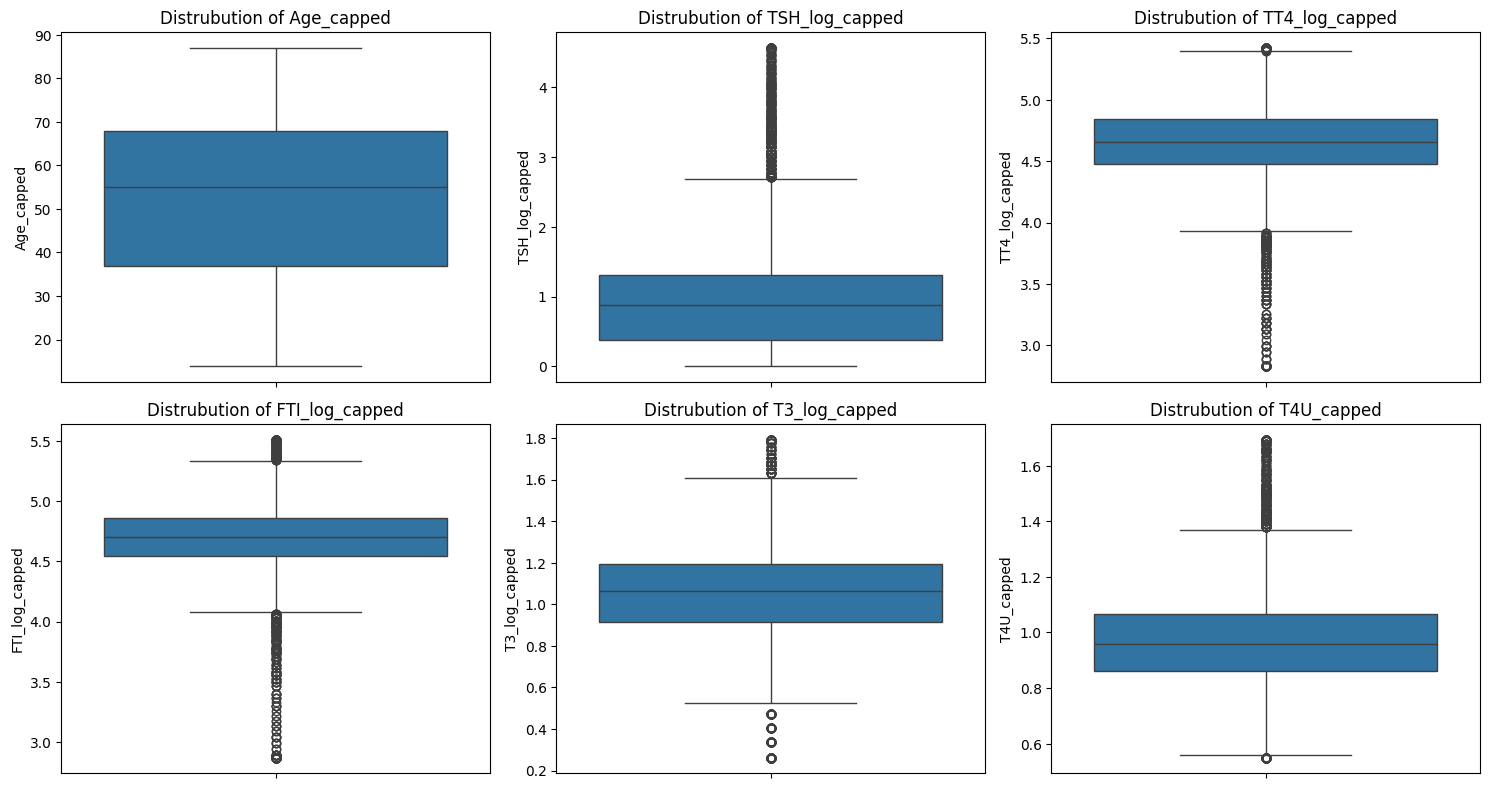

In [19]:
plt.figure(figsize=(15,8))
for i, col in enumerate(robust_features):
  plt.subplot(2,3,i+1)
  sns.boxplot(new_df[col])
  plt.title(f"Distrubution of {col}")

plt.tight_layout()
plt.show()

In [20]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9171 entries, 0 to 9170
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        9171 non-null   int64  
 1   sex                        8864 non-null   object 
 2   on thyroxine               9171 non-null   bool   
 3   query on thyroxine         9171 non-null   bool   
 4   on antithyroid medication  9171 non-null   bool   
 5   sick                       9171 non-null   bool   
 6   pregnant                   9171 non-null   bool   
 7   thyroid surgery            9171 non-null   bool   
 8   I131 treatment             9171 non-null   bool   
 9   query hypothyroid          9171 non-null   bool   
 10  query hyperthyroid         9171 non-null   bool   
 11  lithium                    9171 non-null   bool   
 12  goitre                     9171 non-null   bool   
 13  tumor                      9171 non-null   bool 

In [21]:
col_to_drop = ['age', 'Age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI','TSH_log', 'T3_log', 'TT4_log', 'T4U', 'FTI_log']
df_std = new_df.drop(columns=col_to_drop, axis=1)

In [ ]:
order_of_col = ['Age_capped', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
                'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
                'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_log_capped',
                'T3_log_capped', 'TT4_log_capped', 'T4U_capped', 'FTI_log_capped', 'referral source',
                'class'
                ]

df_std = df_std[order_of_col]

In [22]:
df_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9171 entries, 0 to 9170
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sex                        8864 non-null   object 
 1   on thyroxine               9171 non-null   bool   
 2   query on thyroxine         9171 non-null   bool   
 3   on antithyroid medication  9171 non-null   bool   
 4   sick                       9171 non-null   bool   
 5   pregnant                   9171 non-null   bool   
 6   thyroid surgery            9171 non-null   bool   
 7   I131 treatment             9171 non-null   bool   
 8   query hypothyroid          9171 non-null   bool   
 9   query hyperthyroid         9171 non-null   bool   
 10  lithium                    9171 non-null   bool   
 11  goitre                     9171 non-null   bool   
 12  tumor                      9171 non-null   bool   
 13  hypopituitary              9171 non-null   bool 

In [23]:
df_std.isna().sum()

,0
sex,307
on thyroxine,0
query on thyroxine,0
on antithyroid medication,0
sick,0
pregnant,0
thyroid surgery,0
I131 treatment,0
query hypothyroid,0
query hyperthyroid,0


In [24]:
df_std.sample(5).T

,3938,1807,5590,2737,4262
sex,F,F,F,F,F
on thyroxine,False,False,True,False,False
query on thyroxine,False,False,False,False,False
on antithyroid medication,False,False,False,False,False
sick,False,False,False,False,False
pregnant,False,False,False,False,False
thyroid surgery,False,False,False,False,False
I131 treatment,False,False,True,False,False
query hypothyroid,False,False,True,False,False
query hyperthyroid,False,False,False,False,False


# Dealing NaN Nulls

In [25]:
# Categorical NaNs
df_std['sex'] = df['sex']  # assuming you have this

df_std['sex'] = df_std['sex'].fillna(df_std['sex'].mode()[0])

In [26]:
df_std['sex']

,sex
0,F
1,F
2,F
3,F
4,F
...,...
9166,M
9167,M
9168,M
9169,F


In [27]:
df_std_copy = df_std.copy()

In [28]:
# Numerical NaNs

# Select only numeric columns for imputation
cols_to_impute = ['Age_capped', 'TSH_log_capped', 'T3_log_capped', 'TT4_log_capped', 'T4U_capped', 'FTI_log_capped']
knn_df = df_std_copy[cols_to_impute]

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
knn_imputed = imputer.fit_transform(knn_df)

# Replace original columns
df_std_copy = df_std_copy[cols_to_impute].copy()
df_std_copy[cols_to_impute] = knn_imputed

In [29]:
df_std_copy

,Age_capped,TSH_log_capped,T3_log_capped,TT4_log_capped,T4U_capped,FTI_log_capped
0,29.0,0.955511,1.064711,4.859812,1.182,4.769548
1,41.0,1.212129,1.141799,4.911843,0.888,4.743072
2,36.0,1.065637,1.136101,4.796527,1.010,4.616965
3,32.0,0.230040,1.156202,4.677420,1.114,4.764260
4,60.0,0.667850,0.885843,4.360767,0.896,4.360451
...,...,...,...,...,...,...
9166,56.0,0.925013,1.075934,4.174387,0.830,4.356709
9167,22.0,0.436767,1.094318,4.521789,0.920,4.605170
9168,69.0,0.303052,1.069221,4.736198,1.270,4.499810
9169,47.0,0.926851,0.929254,4.330733,0.850,4.488636


In [30]:
df_std['Age_capped'] = df_std_copy['Age_capped']
df_std['TSH_log_capped'] = df_std_copy['TSH_log_capped']
df_std['T3_log_capped'] = df_std_copy['T3_log_capped']
df_std['TT4_log_capped'] = df_std_copy['TT4_log_capped']
df_std['T4U_capped'] = df_std_copy['T4U_capped']
df_std['FTI_log_capped'] = df_std_copy['FTI_log_capped']

In [31]:
df_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9171 entries, 0 to 9170
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sex                        9171 non-null   object 
 1   on thyroxine               9171 non-null   bool   
 2   query on thyroxine         9171 non-null   bool   
 3   on antithyroid medication  9171 non-null   bool   
 4   sick                       9171 non-null   bool   
 5   pregnant                   9171 non-null   bool   
 6   thyroid surgery            9171 non-null   bool   
 7   I131 treatment             9171 non-null   bool   
 8   query hypothyroid          9171 non-null   bool   
 9   query hyperthyroid         9171 non-null   bool   
 10  lithium                    9171 non-null   bool   
 11  goitre                     9171 non-null   bool   
 12  tumor                      9171 non-null   bool   
 13  hypopituitary              9171 non-null   bool 

In [32]:
# Removing Duplicates

df_std.duplicated().sum()

np.int64(109)

In [33]:
df_std.drop_duplicates(inplace=True)
df_std.reset_index(drop=True, inplace=True)

In [ ]:
df_std.sample(5).T

,1649,6735,5882,8614,2149
Age_capped,70.0,76.0,83.0,54.0,65.0
sex,F,M,F,F,F
on thyroxine,False,False,False,False,True
query on thyroxine,False,False,False,False,False
on antithyroid medication,False,False,False,False,False
sick,False,False,False,False,False
pregnant,False,False,False,False,False
thyroid surgery,False,False,False,False,False
I131 treatment,False,False,False,False,False
query hypothyroid,False,False,False,True,False


In [34]:
# Separate numeric and categorical columns
num_cols = df_std.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df_std.select_dtypes(include='object').columns.difference(['class']).tolist()

In [35]:
print(num_cols)
print(cat_cols)

['Age_capped', 'TSH_log_capped', 'TT4_log_capped', 'FTI_log_capped', 'T3_log_capped', 'T4U_capped']
['referral source', 'sex']


Since these are binary features (yes/no indicators), Option 2 (0/1) is the best choice for Random Forest + MLFS + pipeline:

In [36]:
bool_cols = [
    'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant',
    'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid',
    'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych'
]

In [37]:
# One-Hot Encoding for Bool dtypes Columns

df_std[bool_cols] = df_std[bool_cols].replace({True: 1, False: 0})

<ipython-input-37-3c33cb87abad>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_std[bool_cols] = df_std[bool_cols].replace({True: 1, False: 0})


In [38]:
df_std.rename(columns={
    'Age_capped': 'age',
    'TSH_log_capped': 'TSH',
    'T3_log_capped': 'T3',
    'TT4_log_capped': 'TT4',
    'T4U_capped': 'T4U',
    'FTI_log_capped': 'FTI'
}, inplace=True)


In [39]:
df_cleaned = df_std.copy()

In [40]:
df_cleaned['age'] = df_cleaned['age'].astype(int)

# Encode Categorical Variables
Random Forest doesn’t need scaling but needs Label Encoding or OneHotEncoding for non-boolean categories.

In [41]:
# Encode referral source and other multi-class columns
df_cleaned['referral source'] = LabelEncoder().fit_transform(df_cleaned['referral source'])
df_cleaned['sex'] = LabelEncoder().fit_transform(df_cleaned['sex'])

# Encode target
target_encoder = LabelEncoder()
df_cleaned['class'] = target_encoder.fit_transform(df_cleaned['class'])

X = df_cleaned.drop(columns=['class'])
y = df_cleaned['class']

In [42]:
df_std['class'].value_counts()

,count
class,
negative,6683
hypothyroid conditions,593
general health,561
binding protein,414
replacement therapy,336
discordant results,197
hyperthyroid conditions,182
miscellaneous,63
antithyroid treatment,33


In [43]:
df_cleaned['class'].value_counts()

,count
class,
7,6683
5,593
3,561
1,414
8,336
2,197
4,182
6,63
0,33


# Feature Selection using MLFS (ETC)

In [44]:
y.shape

(9062,)

In [45]:
# ETC for feature importances
etc = ExtraTreesClassifier(n_estimators=200, max_depth=20, criterion='entropy', random_state=42)
etc.fit(X, y)

# Get feature importances
importances = etc.feature_importances_
feature_names = X.columns
selected_features = feature_names[importances > 0.015]
print("Selected Features:", selected_features.tolist())

# Filter dataset
X_selected = X[selected_features]


Selected Features: ['sex', 'on thyroxine', 'referral source', 'age', 'TSH', 'TT4', 'FTI', 'T3', 'T4U']


In [46]:
X_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9062 entries, 0 to 9061
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              9062 non-null   int64  
 1   on thyroxine     9062 non-null   int64  
 2   referral source  9062 non-null   int64  
 3   age              9062 non-null   int64  
 4   TSH              9062 non-null   float64
 5   TT4              9062 non-null   float64
 6   FTI              9062 non-null   float64
 7   T3               9062 non-null   float64
 8   T4U              9062 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 637.3 KB


# Train Random Forest
Based on the research paper we are implementing and following;

[Thyroid Disease Prediction Using Selective Features and Machine Learning Techniques](https://pmc.ncbi.nlm.nih.gov/articles/PMC9405591/#B22-cancers-14-03914)

# Model Training Pipeline

In [ ]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to balance training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


# Random Forest with RandomizedSearchCV for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced_subsample', 'balanced', None],
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_bal, y_train_bal)
print("✅ Best RF parameters:", random_search.best_params_)

# 5. Calibrate the best RF model
best_rf = random_search.best_estimator_
calibrated_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_train_bal, y_train_bal)

# 6. Predict and evaluate
y_pred = calibrated_rf.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best RF parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': None}


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.29      0.24         7
           1       0.60      0.82      0.69        83
           2       0.44      0.64      0.52        39
           3       0.79      0.93      0.86       112
           4       0.54      0.75      0.63        36
           5       0.88      0.96      0.92       119
           6       0.08      0.23      0.12        13
           7       0.98      0.87      0.92      1337
           8       0.71      0.96      0.82        67

    accuracy                           0.87      1813
   macro avg       0.58      0.72      0.63      1813
weighted avg       0.90      0.87      0.88      1813



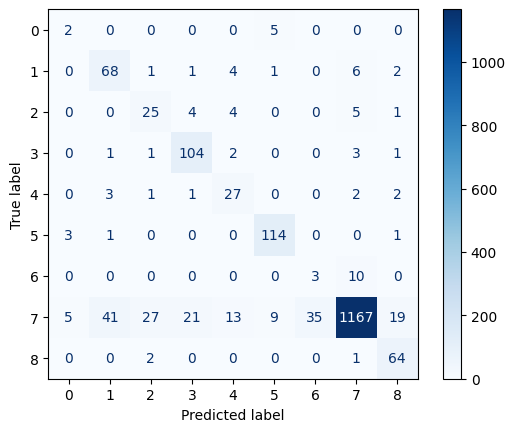

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(calibrated_rf, X_test, y_test, cmap='Blues')

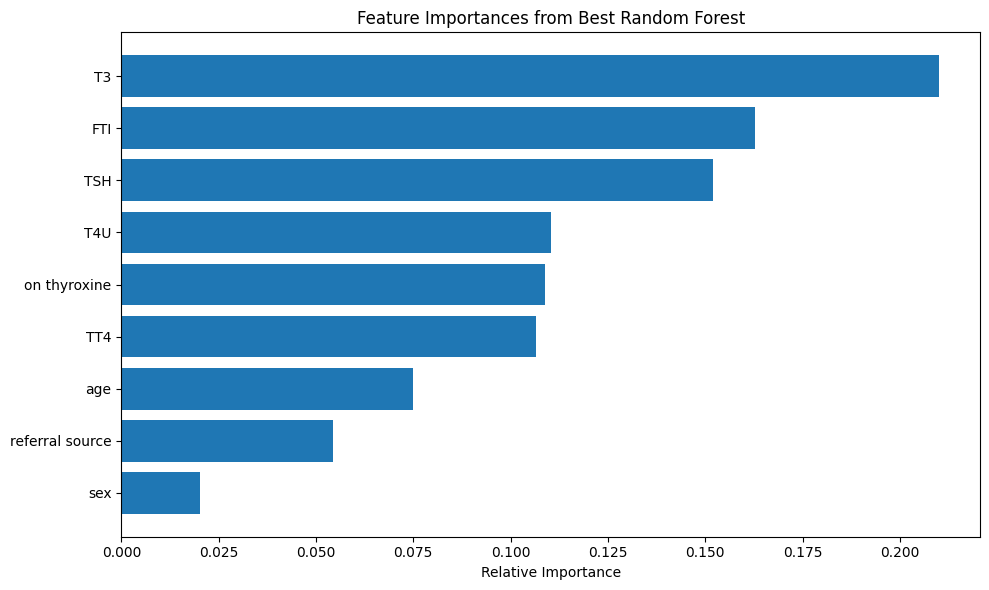

In [ ]:
importances = best_rf.feature_importances_
feature_names = X_selected.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Best Random Forest")
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Models dictionary
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, clf in models.items():
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42,  k_neighbors=1)),
        ('classifier', clf)
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    results[name] = scores
    print(f"{name} - Mean Macro F1: {scores.mean():.4f} (Std: {scores.std():.4f})")

Random Forest - Mean Macro F1: 0.6689 (Std: 0.0338)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:33:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:33:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:33:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:33:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:33:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost - Mean Macro F1: 0.6694 (Std: 0.0353)
CatBoost - Mean Macro F1: 0.6668 (Std: 0.0169)
Logistic Regression - Mean Macro F1: 0.4308 (Std: 0.0170)
SVM - Mean Macro F1: 0.5684 (Std: 0.0202)
KNN - Mean Macro F1: 0.5442 (Std: 0.0300)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP - Mean Macro F1: 0.5870 (Std: 0.0224)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [47]:
# Assuming df_cleaned is your DataFrame and 'class' is the column of interest
value_counts_series = new_df['class'].value_counts()
value_names = value_counts_series.index.tolist()

print("Value names in the 'class' column:")
print(value_names)
print(new_df['class'].value_counts())

Value names in the 'class' column:
['negative', 'hypothyroid conditions', 'general health', 'binding protein', 'replacement therapy', 'discordant results', 'hyperthyroid conditions', 'miscellaneous', 'antithyroid treatment']
class
negative                   6770
hypothyroid conditions      593
general health              561
binding protein             414
replacement therapy         336
discordant results          197
hyperthyroid conditions     182
miscellaneous                85
antithyroid treatment        33
Name: count, dtype: int64


In [48]:
print(df_cleaned['class'].value_counts())

class
7    6683
5     593
3     561
1     414
8     336
2     197
4     182
6      63
0      33
Name: count, dtype: int64


# Downsampling

# Map to 5 grouped classes
group_map = {
    7: 0,              # Normal -> 7:Negative

    5: 1, 8: 1,        # Hypothyroid-related -> 5:Hypothyroid | 8:Replacement Therapy
    4: 2, 0: 2,        # Hyperthyroid-related -> 4:Hyperthyroid | 0:anti-thyroid treat
    1: 3, 2: 3,        # Unclear/ambiguous (other) -> 1:Binding Protein | 2:Discordant Results
    3:4, 2: 4          # Lab anomalies/non-thyroid-related -> 3:General Health | 6:Miscellaneous
}


In [49]:
# Map to 5 grouped classes
group_map = {
    7: 0,              # Normal -> 7:Negative
    5: 1, 8: 1,        # Hypothyroid-related -> 5:Hypothyroid | 8:Replacement Therapy
    4: 2, 0: 2,        # Hyperthyroid-related -> 4:Hyperthyroid | 0:anti-thyroid treat
    1: 3, 2: 3,        # Unclear/ambiguous (other) -> 1:Binding Protein | 2:Discordant Results
    3:4, 2: 4          # Lab anomalies/non-thyroid-related -> 3:General Health | 6:Miscellaneous
}


In [50]:
copy_df_cleaned = df_cleaned.copy()

copy_df_cleaned['class'] = df_cleaned['class'].map(group_map)

In [51]:
copy_df_cleaned['class'].isna().sum()

np.int64(63)

In [52]:
copy_df_cleaned.dropna(subset=['class'], inplace=True)

In [53]:
copy_df_cleaned.shape

(8999, 23)

In [54]:
copy_df_cleaned['class'].isna().sum()

np.int64(0)

In [55]:
copy_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8999 entries, 0 to 9061
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sex                        8999 non-null   int64  
 1   on thyroxine               8999 non-null   int64  
 2   query on thyroxine         8999 non-null   int64  
 3   on antithyroid medication  8999 non-null   int64  
 4   sick                       8999 non-null   int64  
 5   pregnant                   8999 non-null   int64  
 6   thyroid surgery            8999 non-null   int64  
 7   I131 treatment             8999 non-null   int64  
 8   query hypothyroid          8999 non-null   int64  
 9   query hyperthyroid         8999 non-null   int64  
 10  lithium                    8999 non-null   int64  
 11  goitre                     8999 non-null   int64  
 12  tumor                      8999 non-null   int64  
 13  hypopituitary              8999 non-null   int64  
 1

In [56]:
copy_df_cleaned['class'] = copy_df_cleaned['class'].astype(int)

In [57]:
copy_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8999 entries, 0 to 9061
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sex                        8999 non-null   int64  
 1   on thyroxine               8999 non-null   int64  
 2   query on thyroxine         8999 non-null   int64  
 3   on antithyroid medication  8999 non-null   int64  
 4   sick                       8999 non-null   int64  
 5   pregnant                   8999 non-null   int64  
 6   thyroid surgery            8999 non-null   int64  
 7   I131 treatment             8999 non-null   int64  
 8   query hypothyroid          8999 non-null   int64  
 9   query hyperthyroid         8999 non-null   int64  
 10  lithium                    8999 non-null   int64  
 11  goitre                     8999 non-null   int64  
 12  tumor                      8999 non-null   int64  
 13  hypopituitary              8999 non-null   int64  
 1

In [58]:
print(copy_df_cleaned['class'].value_counts())

class
0    6683
1     929
4     758
3     414
2     215
Name: count, dtype: int64



{

    7: 0,              # Normal -> 7:Negative
    5: 1, 8: 1,        # Hypothyroid-related -> 5:Hypothyroid | 8:Replacement Therapy
    4: 2, 0: 2,        # Hyperthyroid-related -> 4:Hyperthyroid | 0:anti-thyroid treat
    1: 3, 2: 3,        # Other (Unclear/ambiguous) -> 1:Binding Protein | 2:Discordant Results
    3:4, 2: 4          # Misc (Lab anomalies/non-thyroid-related) -> 3:General Health | 6:Miscellaneous
}


In [59]:
# Downsample the 'normal' diagnosis class only to 2000
normal_df = copy_df_cleaned[copy_df_cleaned['class'] == 0].sample(n=2000, random_state=42)

# Include all rows from other classes as they are
hypo_df = copy_df_cleaned[copy_df_cleaned['class'] == 1]
hyper_df = copy_df_cleaned[copy_df_cleaned['class'] == 2]
other_df = copy_df_cleaned[copy_df_cleaned['class'] == 3]
misc_df = copy_df_cleaned[copy_df_cleaned['class'] == 4]

In [60]:
df_bal = pd.concat([normal_df, hypo_df, hyper_df, other_df, misc_df]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_bal['class'].value_counts())

class
0    2000
1     929
4     758
3     414
2     215
Name: count, dtype: int64


In [61]:
df_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4316 entries, 0 to 4315
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sex                        4316 non-null   int64  
 1   on thyroxine               4316 non-null   int64  
 2   query on thyroxine         4316 non-null   int64  
 3   on antithyroid medication  4316 non-null   int64  
 4   sick                       4316 non-null   int64  
 5   pregnant                   4316 non-null   int64  
 6   thyroid surgery            4316 non-null   int64  
 7   I131 treatment             4316 non-null   int64  
 8   query hypothyroid          4316 non-null   int64  
 9   query hyperthyroid         4316 non-null   int64  
 10  lithium                    4316 non-null   int64  
 11  goitre                     4316 non-null   int64  
 12  tumor                      4316 non-null   int64  
 13  hypopituitary              4316 non-null   int64

In [62]:
df_bal.isna().sum().sum()

np.int64(0)

In [63]:
df_bal['referral source'].value_counts()

,count
referral source,
5,2494
3,1241
1,376
0,164
2,38
4,3


In [65]:
df_bal = df_bal.rename(columns={'on thyroxine': 'on_thyroxine', 'referral source': 'referral_source'})

In [68]:
selected_features = ['age', 'sex', 'on_thyroxine', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'referral_source']

X = df_bal[selected_features]
y = df_bal['class']

In [69]:
X.shape

(4316, 9)

In [70]:
y.shape

(4316,)

In [71]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train Random Forest

In [72]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       400
           1       0.96      0.98      0.97       186
           2       0.76      0.74      0.75        43
           3       0.80      0.92      0.85        83
           4       0.88      0.95      0.91       152

    accuracy                           0.92       864
   macro avg       0.88      0.90      0.89       864
weighted avg       0.93      0.92      0.93       864



# Train CatBoost

In [75]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       400
           1       0.95      0.98      0.97       186
           2       0.82      0.74      0.78        43
           3       0.84      0.92      0.87        83
           4       0.85      0.94      0.89       152

    accuracy                           0.93       864
   macro avg       0.89      0.90      0.89       864
weighted avg       0.93      0.93      0.93       864



Stratified Cross-Validation (to average over random test splits)

In [76]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='f1_macro')
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=skf, scoring='f1_macro')


print(f"Random Forest CV Macro F1: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"CatBoost CV Macro F1: {cat_scores.mean():.4f} ± {cat_scores.std():.4f}")

Random Forest CV Macro F1: 0.8687 ± 0.0151
CatBoost CV Macro F1: 0.8605 ± 0.0105


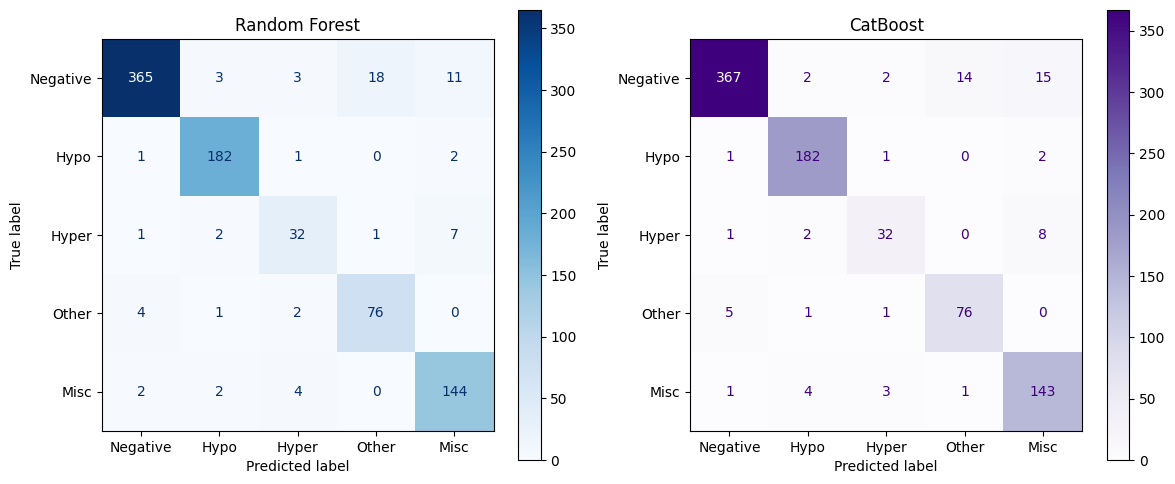

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions
rf_preds = rf_model.predict(X_test)
cb_preds = cat_model.predict(X_test)    # 'cb' for catboost

# Class labels
class_names = ['Negative', 'Hypo', 'Hyper', 'Other', 'Misc']

# Confusion matrices
rf_cm = confusion_matrix(y_test, rf_preds)
cb_cm = confusion_matrix(y_test, cb_preds)

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=class_names)
disp_rf.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Random Forest")

# CatBoost
disp_cb = ConfusionMatrixDisplay(confusion_matrix=cb_cm, display_labels=class_names)
disp_cb.plot(ax=axes[1], cmap='Purples', values_format='d')
axes[1].set_title("CatBoost")

plt.tight_layout()
plt.show()


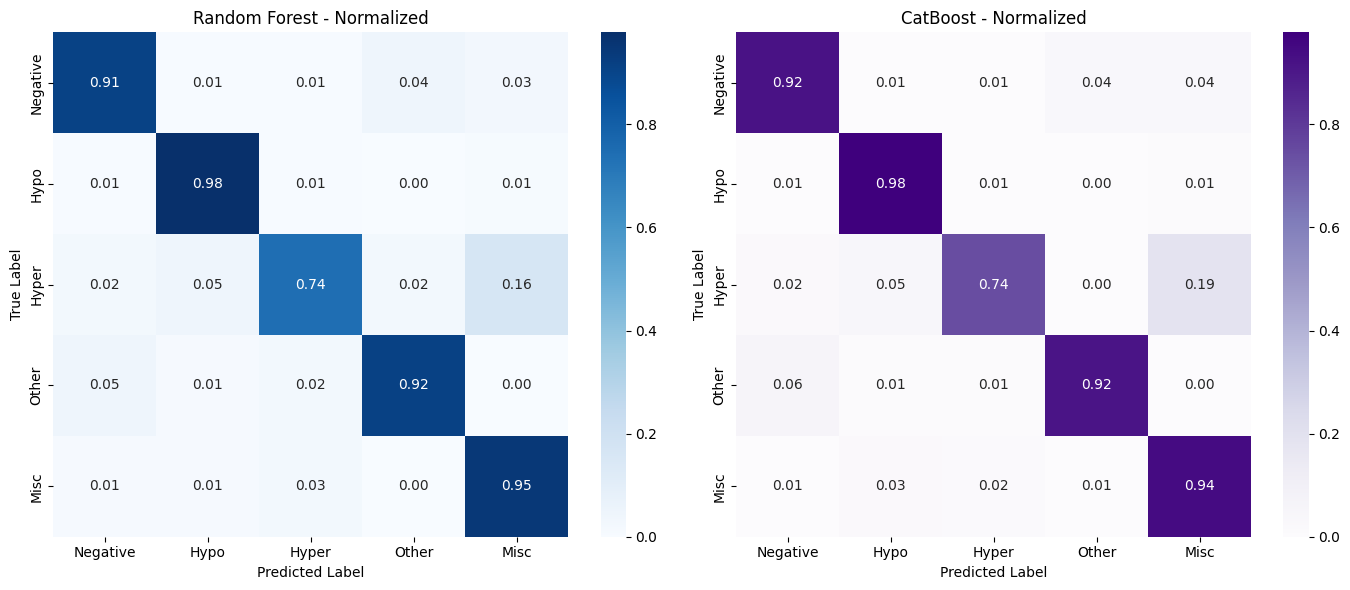

In [78]:
# Compute normalized confusion matrices
rf_cm = confusion_matrix(y_test, rf_preds, normalize='true')
cb_cm = confusion_matrix(y_test, cb_preds, normalize='true')

labels = ['Negative', 'Hypo', 'Hyper', 'Other', 'Misc']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(rf_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Random Forest - Normalized")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cb_cm, annot=True, fmt=".2f", cmap="Purples", xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("CatBoost - Normalized")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


# Precision, Recall, F1 by Class

In [79]:
rf_report = classification_report(y_test, rf_preds, output_dict=True)
cb_report = classification_report(y_test, cb_preds, output_dict=True)

rf_df = pd.DataFrame(rf_report).T.loc[['0', '1', '2', '3', '4']]
cb_df = pd.DataFrame(cb_report).T.loc[['0', '1', '2', '3', '4']]

comparison_df = pd.concat([rf_df, cb_df], axis=1, keys=['Random Forest', 'CatBoost'])
print(comparison_df.T)


                                  0           1          2          3  \
Random Forest precision    0.978552    0.957895   0.761905   0.800000   
              recall       0.912500    0.978495   0.744186   0.915663   
              f1-score     0.944373    0.968085   0.752941   0.853933   
              support    400.000000  186.000000  43.000000  83.000000   
CatBoost      precision    0.978667    0.952880   0.820513   0.835165   
              recall       0.917500    0.978495   0.744186   0.915663   
              f1-score     0.947097    0.965517   0.780488   0.873563   
              support    400.000000  186.000000  43.000000  83.000000   

                                  4  
Random Forest precision    0.878049  
              recall       0.947368  
              f1-score     0.911392  
              support    152.000000  
CatBoost      precision    0.851190  
              recall       0.940789  
              f1-score     0.893750  
              support    152.000000  


# Need to Save Best Model


In [93]:
import joblib
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [81]:
selected_features = ['age', 'sex', 'on_thyroxine', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'referral_source']
joblib.dump(selected_features, "selected_features.pkl")

['selected_features.pkl']

In [89]:
df_std['class'].value_counts()

,count
class,
negative,6683
hypothyroid conditions,593
general health,561
binding protein,414
replacement therapy,336
discordant results,197
hyperthyroid conditions,182
miscellaneous,63
antithyroid treatment,33


In [92]:
Class = {0:'negative', 1:'hypothyroid', 2:'hyperthyroid', 3:'other', 4:'misc'}
joblib.dump(Class, "class.pkl")

['class.pkl']

In [ ]:
df_std['referralsource'].value_counts()

In [ ]:
df_bal['referral source'].value_counts()

In [82]:
referral_source = {'STMW': 0, 'SVHC': 1,  'SVHD': 2, 'SVI': 3,  'WEST': 4, 'other': 5}
joblib.dump(referral_source, "referral_source.pkl")

['referral_source.pkl']

In [ ]:
df_std['sex'].value_counts()

In [ ]:
df_bal['sex'].value_counts()

In [ ]:
sex = {'F': 0, 'M': 1}
joblib.dump(sex, "sex.pkl")

In [ ]:
new_df['on thyroxine'].value_counts()

In [ ]:
df_bal['on thyroxine'].value_counts()

In [83]:
on_thyroxine = {'False': 0, 'True': 1}
joblib.dump(on_thyroxine, "on_thyroxine.pkl")

['on_thyroxine.pkl']

# Use IQR method to detect & remove outliers
The IQR method is robust, avoids distortion from extreme values, and is commonly used in medical datasets.

In [ ]:
# def remove_outliers_iqr(new_df, columns, factor=1.5):
#     clean_df = new_df.copy()
#     for col in columns:
#         Q1 = clean_df[col].quantile(0.25)
#         Q3 = clean_df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - factor * IQR
#         upper_bound = Q3 + factor * IQR
#         clean_df = clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]
#     return clean_df